In [192]:
import pandas as pd
import numpy as np

In [369]:
OneHotCategoricalEncoder

feature_engine.categorical_encoders.OneHotCategoricalEncoder

In [193]:
data=pd.read_csv('banamex_train.csv')
data.shape

(50000, 12)

# Verificamos porcentaje de valores pérdidos dentro de las variables

In [194]:
data.isna().mean()

User_ID                       0.00000
Product_ID                    0.00000
Gender                        0.00000
Age                           0.00000
Occupation                    0.00000
City_Category                 0.00000
Stay_In_Current_City_Years    0.00000
Marital_Status                0.00000
Product_Category_1            0.00000
Product_Category_2            0.31314
Product_Category_3            0.69520
Purchase                      0.00000
dtype: float64

# Quitamos Product_Category_2 y Product_Category_3 dado que tienen más del 20% de valores pérdidos por otro lado User_ID y Product_ID tampoco serán variables de interés para modelar

In [195]:
data=data[['Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
      'Purchase']]

In [196]:
data.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Purchase
0,M,18-25,19,C,4+,0,5,3522
1,M,51-55,12,C,4+,1,1,11654
2,M,18-25,4,B,2,0,5,3456
3,M,26-35,7,A,2,1,2,13288
4,M,26-35,16,A,1,1,8,5915


# Ventas a modelar

### Podemos observar que la serie parece ser ruido blanco 

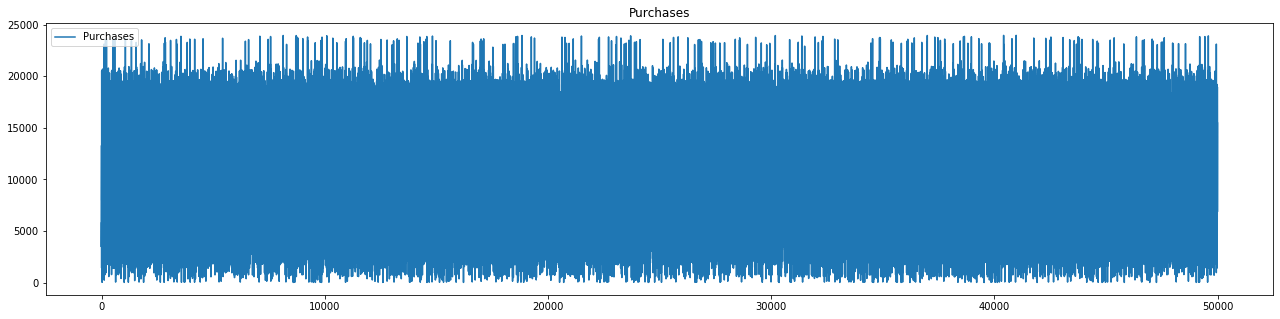

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns

data.Purchase.plot(figsize=(22,5),label='Purchases')

plt.title("Purchases")
plt.legend(loc="upper left")
plt.show()

# Exploración de las ventas

In [199]:
data['Purchase'].describe()

count    50000.000000
mean      9310.391120
std       5025.193953
min         12.000000
25%       5861.000000
50%       8063.500000
75%      12086.000000
max      23961.000000
Name: Purchase, dtype: float64

### Para comprobar que la serie es ruido blanco, necesitamos verificar 3 criterio

1.- Media constante

2.- Varianza constante 

3.- Sin autocorrelaciones

## Verifiquemos media constante y varianza constante

Si la serie de datos es estacionario podemos decir que tienen media y varianza constante

Utilizaremos la prueba de Dicky Fuller para comprobar esta hipotesis 

In [206]:
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 

### De esta prueba podemos concluir que para cualquier nivel de significancia la serie es estacionaria

In [207]:
sts.adfuller(data.Purchase)

(-222.76927866726555,
 0.0,
 0,
 49999,
 {'1%': -3.4304807953310763,
  '5%': -2.8615978088501315,
  '10%': -2.566800769739017},
 992957.720064805)

# Veamos las correlaciones de 40 retrasos

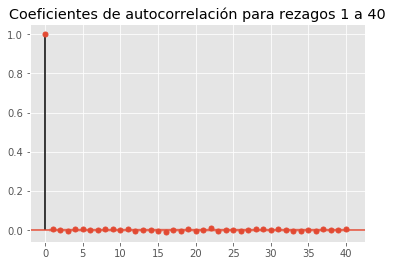

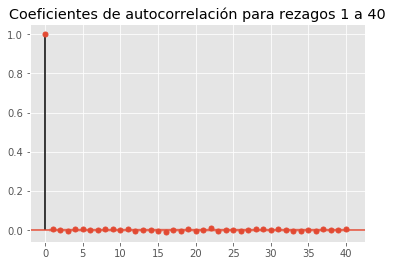

In [208]:
import statsmodels.graphics.tsaplots as tsa
tsa.plot_acf(data['Purchase'], lags = 40, alpha = 0.05, title = 'Coeficientes de autocorrelación para rezagos 1 a 40')

### Utilice el estadístico q de Ljung-Box para comprobar si una serie de observaciones en un período de tiempo específico son aleatorias.

#### Esta es una prueba estadística unilateral, un valor p mayor que el nivel de importancia (α) nos lleva a no rechazar la hipótesis nula o, en otras palabras, la serie de tiempo es ruido blanco.

In [166]:
import statsmodels.stats.diagnostic as diag 
diag. acorr_ljungbox ( data ['Purchase'] , lags = [40], boxpierce = True , model_df = 0 , period = None , return_df = None )

C:\Users\usuario\AppData\Roaming\Python\Python37\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


(array([41.4367122]),
 array([0.40782277]),
 array([41.41817591]),
 array([0.40860791]))

El valor de p de 0.40 indica que debemos aceptar la hipótesis de que los datos son ruido blanco. La prueba de Ljung-Box  piensa que este conjunto de datos ha sido generado por un proceso aleatorio puro.

Si la muestra es ruido blanco, son arbitrarios y no se puede predecir dado que no sigue ningún patrón, por lo que para dar una estimación podriamos predecir con los del pasado, dado que el comportamiento del pasado persiste en el futuro, esto sugiere que las mejores predicciones para los ventas de hoy, serán los ventas de ayer.

Sin embargo, no podremos predecir con gran precisión periodos muy lejanos dado que dependeremos de estimaciones, no de datos.

In [209]:
df_predict=pd.DataFrame(data.Purchase)
df_predict['predict'] = data['Purchase'].shift(1)

In [211]:
df_predict.head()

,Purchase,predict
0,3522,NaN
1,11654,3522.0
2,3456,11654.0
3,13288,3456.0
4,5915,13288.0


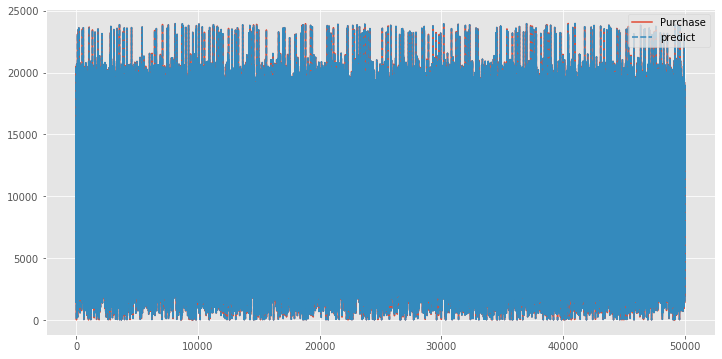

In [212]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_predict)

In [213]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error


def metricas(y_true,y_pred):
    r2=r2_score(y_true,y_pred)
    mae=mean_absolute_error(y_true,y_pred)
    mse=mean_squared_error(y_true,y_pred)
    print(f'El r2 score es {r2}')
    print(f'El error cuadrático medio es {mse}')
    print(f'El error medio absoluto es {mae}')
   

In [217]:
metricas(df_predict['Purchase'][1:],df_predict['predict'][1:])

El r2 score es -0.9925550017167661
El error cuadrático medio es 50315807.87883758
El error medio absoluto es 5605.64839296786
